In [37]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt


## Data pre-processing

In [38]:
# read data
d=pd.read_csv('Neuropsych.csv')

# map non-numerical categorical variables to discrete numerical values
d['diag'] = d['Dg.'].apply(lambda x: {'ADHD+BPD':0,'ADHD':-1,'BPD':1}[x])
d['gender'] = d['Pohlaví '].apply(lambda x: {'Ž':0,'Z':0,'M':1,'M ': 1,'T':2}[x])

# discard unimportant and renamed features
d=d.drop(columns=['Věk'])
d=d.drop(columns=['gender'])
d=d.drop(columns=['BPQ_SUM','Jméno','Pohlaví ','Dg.'])

# replace noise, wrong inputs, NOKs, and other representations
# of NaNs with actual NaNs
d = d.replace({'X': np.nan})
d = d.replace({'!': np.nan})
d = d.replace({'x': np.nan})
d = d.replace({'6(16)': np.nan})
d = d.replace({',': '.'},regex=True)
d = d.replace({'chybovost': np.nan})
d = d.replace({'107 (nedokončeno)': np.nan})
d = d.replace({'35(16+19)': np.nan})


# map non-numerical categorical variable OK/NOK to 1/0 respectively
d['ROCFT_PLAN'] = d['ROCFT_PLAN'].apply(lambda x: {'OK':1,'NOK':0}[x] if x==x else np.nan)

# remove rows with more than 20% NaNs 
d=d.dropna(thresh=len(d.columns)*0.80)

# make all values numerical
for feature in d.columns:
    d[feature] = d[feature].astype(float)

# fill in missing values with median
d=d.fillna(d.median())

# standardize all values
y = d['diag']
d = d.drop(columns=['diag'])
d = d.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
d['diag'] = y


## Function definitions

In [39]:
def LOOCV(clf,train_data):
    loo = LeaveOneOut()
    """
    Perform Leave-One-Out Cross-Validation (LOOCV) using a classifier.

    Parameters:
        clf (classifier object): The classifier object that implements the `fit` and `predict` methods.
        train_data (pandas DataFrame): The training dataset with the target variable labeled as "diag"
                                       and the features in other columns.

    Returns:
        float: The mean F1 score of the classifier evaluated using LOOCV.

    Procedure:
        1. Initialize a LeaveOneOut object to generate the indices for each training-test split.
        2. Create an empty list to store the F1 scores for each split.
        3. Separate the features and target variable from the training dataset.
        4. Iterate over the splits generated by LeaveOneOut:
            - Extract the training and test data for each split.
            - Fit the classifier on the training data.
            - Predict the target variable for the test data.
            - Calculate the F1 score for the predicted and true values.
            - Append the calculated F1 score to the scores list.
        5. Calculate the mean of the F1 scores.
        6. Return the mean F1 score.
    """
    # initialize a list to store the scores
    scores = []

    X = train_data.drop(columns=["diag"])
    y = train_data.diag
    # iterate over the splits
    for train_index, test_index in loo.split(X):
        # get the training and test data for this split
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # fit the model on the training data and score it on the test data
        clf.fit(X_train, y_train)
        score = f1_score(y_test,clf.predict(X_test),average="macro")
        
        # store the score
        scores.append(score)

    # calculate and print the mean score
    return sum(scores) / len(scores)

In [40]:
def eval(clf,test_data):
    """
    Evaluate the performance of a classifier on the test data using the F1 score.

    Parameters:
        clf (classifier object): The trained classifier object that implements the `predict` method.
        test_data (pandas DataFrame): The test dataset with the target variable labeled as "diag"
                                      and the features in other columns.

    Returns:
        float: The F1 score of the classifier on the test data.

    """
    y_pred = clf.predict(test_data.drop(columns=['diag']))
    return f1_score(test_data.diag,y_pred,average="macro")
    
def fit_on_train(clf,train_data):
    """
    Fit a classifier on the training data.

    Parameters:
        clf (classifier object): The classifier object that implements the `fit` method.
        train_data (pandas DataFrame): The training dataset with the target variable labeled as "diag"
                                       and the features in other columns.

    Returns:
        classifier object: The trained classifier object.
    """
    clf.fit(train_data.drop(columns=['diag']), train_data.diag)
    return clf

In [41]:
def fit_and_eval_LOOCV(d):
    """
    Fit and evaluate multiple classifiers using Leave-One-Out Cross-Validation (LOOCV).

    Parameters:
        data (pandas DataFrame): The dataset with the target variable labeled as "diag" and the features in other columns.

    Returns:
        None
    """
    classifiers=[LogisticRegression(random_state=42,class_weight='balanced',solver='newton-cg'),
                 KNeighborsClassifier(),
                 RandomForestClassifier(random_state=42),
                 svm.SVC(kernel='linear',random_state=42),
                 DecisionTreeClassifier(random_state=42,max_depth=6),
                 GaussianNB(),
                 GradientBoostingClassifier(random_state=42),
                 AdaBoostClassifier(random_state=42)]
    scores = []
    for clf in tqdm(classifiers):
        scores.append(LOOCV(clf,d))
        print(clf,scores[-1])

## Feature correlations

In [42]:
df_analysis = d.drop(columns=['diag','ROCFT_PLAN'])

<AxesSubplot: >

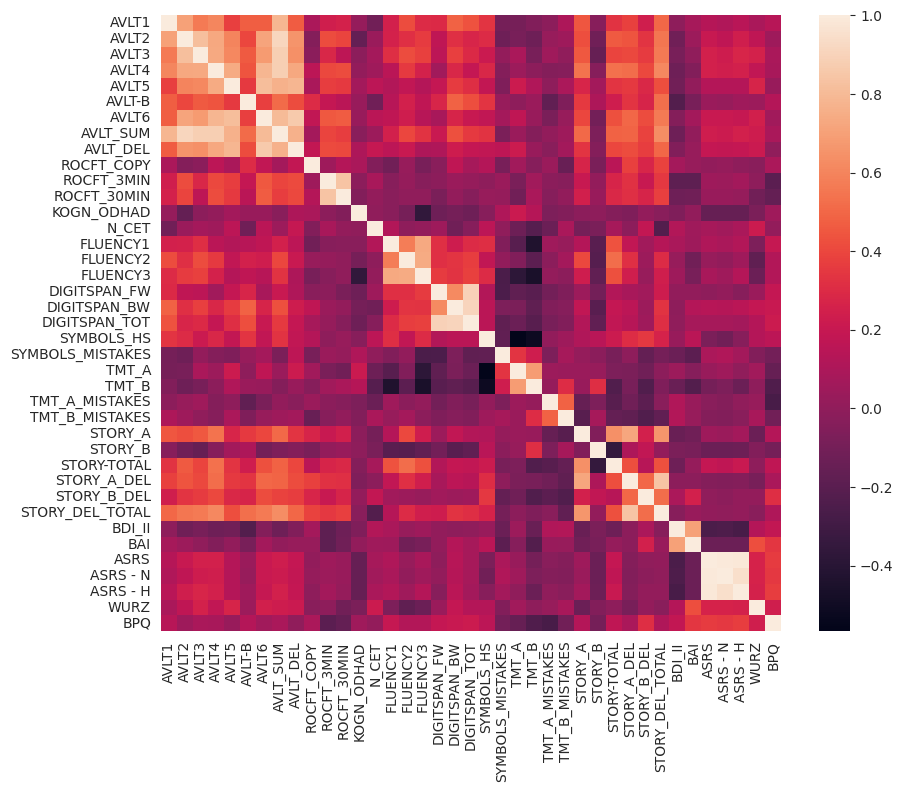

In [43]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_analysis.corr(method='pearson'),ax=ax)


[Text(0.5, 0, 'AVLT1'),
 Text(1.5, 0, 'AVLT2'),
 Text(2.5, 0, 'AVLT3'),
 Text(3.5, 0, 'AVLT4'),
 Text(4.5, 0, 'AVLT5'),
 Text(5.5, 0, 'AVLT6'),
 Text(6.5, 0, 'AVLT-B'),
 Text(7.5, 0, 'AVLT_DEL'),
 Text(8.5, 0, 'AVLT_SUM')]

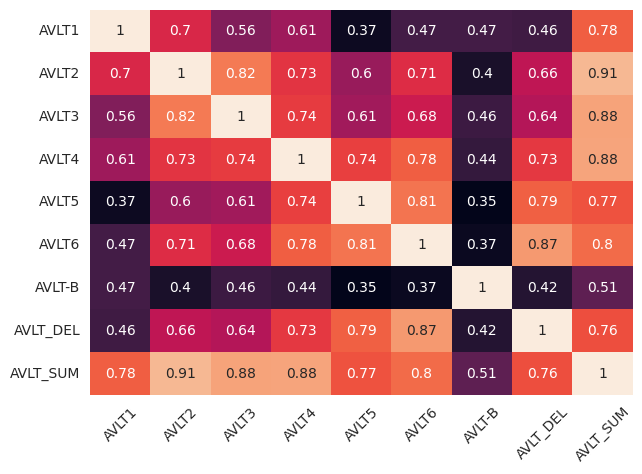

In [44]:
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(df_analysis[['AVLT1','AVLT2','AVLT3','AVLT4','AVLT5','AVLT6','AVLT-B','AVLT_DEL','AVLT_SUM']].corr(method='pearson'),ax=ax,annot=True,cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

<AxesSubplot: >

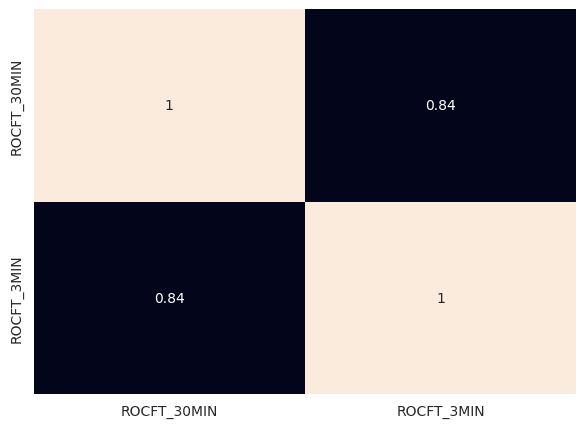

In [45]:
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(df_analysis[['ROCFT_30MIN','ROCFT_3MIN']].corr(method='pearson'),ax=ax,annot=True,cbar=False)


<AxesSubplot: >

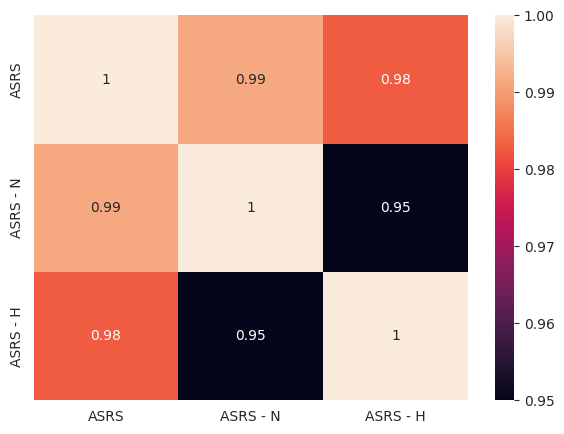

In [46]:
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(df_analysis[['ASRS','ASRS - N','ASRS - H']].corr(method='pearson'),ax=ax,annot=True)


<AxesSubplot: >

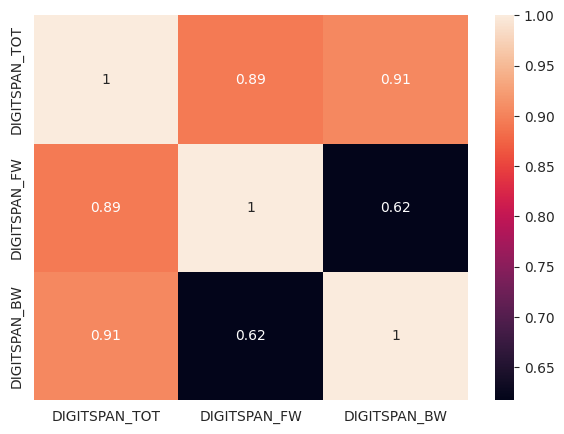

In [47]:
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(df_analysis[['DIGITSPAN_TOT','DIGITSPAN_FW','DIGITSPAN_BW']].corr(method='pearson'),ax=ax,annot=True)


In [48]:
import numpy as np
from scipy.stats import kruskal
indeces=[]
for idx,feature in enumerate(d.columns):
    
    # Perform the Kruskal-Wallis test
    statistic, p_value = kruskal(*[d[feature][d.diag == category] for category in np.unique(d.diag)])
    
    if p_value <= 0.05 and feature!='diag':
        indeces.append(idx)
        print(feature)
        print(p_value)

AVLT_DEL
0.04876232745325839
BDI_II
0.0063172799599124085
BAI
0.007366220913404045
ASRS
0.002019850167006132
ASRS - N
0.003880233532818689
ASRS - H
0.001267287205840376


## Making collapsed version of the dataset

In [49]:
df = d

df['AVLT_AGG'] = df[['AVLT1','AVLT2','AVLT3','AVLT4','AVLT5','AVLT6','AVLT-B','AVLT_DEL']].mean(axis=1)
df = df.drop(columns=['AVLT1','AVLT2','AVLT3','AVLT4','AVLT5','AVLT6','AVLT-B','AVLT_DEL','AVLT_SUM'])

df['ROCFT_AGG'] = df[['ROCFT_3MIN','ROCFT_30MIN']].mean(axis=1)
df = df.drop(columns=['ROCFT_3MIN','ROCFT_30MIN','ROCFT_COPY','ROCFT_PLAN'])

df['FLUENCY_AGG'] = df[['FLUENCY1','FLUENCY2','FLUENCY3']].mean(axis=1)
df = df.drop(columns=['FLUENCY1','FLUENCY2','FLUENCY3'])

df['DIGITSPAN_AGG'] = df[['DIGITSPAN_FW','DIGITSPAN_BW']].mean(axis=1)
df = df.drop(columns=['DIGITSPAN_FW','DIGITSPAN_BW','DIGITSPAN_TOT'])

df['TMT_AGG'] = df[['TMT_A','TMT_B']].mean(axis=1)
df = df.drop(columns=['TMT_A','TMT_B'])

df['STORY_AGG'] = df[['STORY_A_DEL','STORY_B_DEL','STORY_A','STORY_B']].mean(axis=1)
df = df.drop(columns=['STORY_A_DEL','STORY_B_DEL','STORY_A','STORY_B','STORY-TOTAL','STORY_DEL_TOTAL'])

df['ASRS_AGG'] = df[['ASRS','ASRS - N','ASRS - H']].mean(axis=1)
df = df.drop(columns=['ASRS','ASRS - N','ASRS - H'])

df['MISTAKES_AGG'] = df[['TMT_A_MISTAKES','SYMBOLS_MISTAKES','TMT_B_MISTAKES']].mean(axis=1)
df = df.drop(columns=['TMT_A_MISTAKES','SYMBOLS_MISTAKES','TMT_B_MISTAKES'])

## Choosing the best model

### Random guessing

In [51]:
score=0
for i in range(1000):
    score+=f1_score(d.diag,np.random.choice([-1,0,1],size=len(d.diag)),average="macro")
random_guesser = score/1000
print(random_guesser)

0.3041250682928091


### Full data

In [52]:
fit_and_eval_LOOCV(d)

 12%|█▎        | 1/8 [00:00<00:03,  1.78it/s]

LogisticRegression(class_weight='balanced', random_state=42, solver='newton-cg') 0.559322033898305


 25%|██▌       | 2/8 [00:01<00:03,  1.82it/s]

KNeighborsClassifier() 0.559322033898305


 38%|███▊      | 3/8 [00:08<00:18,  3.60s/it]

RandomForestClassifier(random_state=42) 0.6779661016949152


 50%|█████     | 4/8 [00:08<00:09,  2.30s/it]

SVC(kernel='linear', random_state=42) 0.576271186440678


 62%|██████▎   | 5/8 [00:08<00:04,  1.56s/it]

DecisionTreeClassifier(max_depth=6, random_state=42) 0.5084745762711864


 75%|███████▌  | 6/8 [00:09<00:02,  1.11s/it]

GaussianNB() 0.2542372881355932


 88%|████████▊ | 7/8 [00:25<00:06,  6.25s/it]

GradientBoostingClassifier(random_state=42) 0.5932203389830508


100%|██████████| 8/8 [00:30<00:00,  3.77s/it]

AdaBoostClassifier(random_state=42) 0.576271186440678


[Text(0, 0, 'RandomForest'),
 Text(1, 0, 'GradientBoosting'),
 Text(2, 0, 'AdaBoost'),
 Text(3, 0, 'SVM'),
 Text(4, 0, 'KNeighbors'),
 Text(5, 0, 'LogisticRegression'),
 Text(6, 0, 'DecisionTree'),
 Text(7, 0, 'Random Guessing'),
 Text(8, 0, 'GaussianNB')]

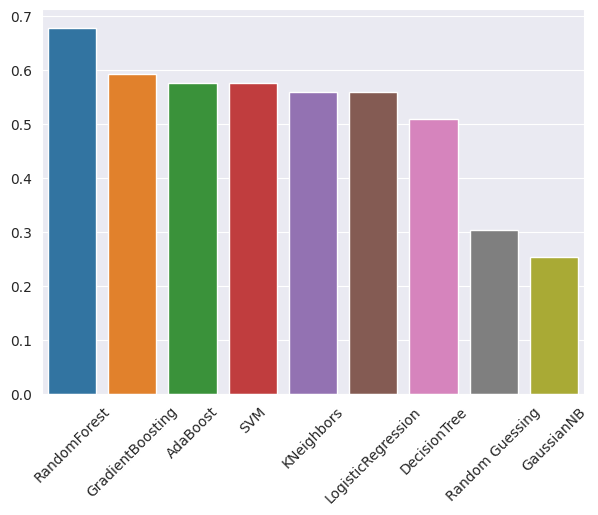

In [54]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(7,5))

values = np.array([0.559322033898305,0.559322033898305,0.6779661016949152,
                   0.576271186440678,0.5084745762711864,0.2542372881355932,
                   0.5932203389830508,0.576271186440678,0.3041250682928091])
labels = np.array(["LogisticRegression","KNeighbors","RandomForest","SVM","DecisionTree","GaussianNB","GradientBoosting","AdaBoost","Random Guessing"])
sns.barplot(x=labels[np.argsort(values)][::-1],y=np.sort(values)[::-1])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)    


### Collapsed data

In [55]:
fit_and_eval_LOOCV(df)

 12%|█▎        | 1/8 [00:00<00:03,  2.11it/s]

LogisticRegression(class_weight='balanced', random_state=42, solver='newton-cg') 0.5084745762711864


 25%|██▌       | 2/8 [00:00<00:01,  3.12it/s]

KNeighborsClassifier() 0.5932203389830508


 38%|███▊      | 3/8 [00:07<00:16,  3.23s/it]

RandomForestClassifier(random_state=42) 0.6101694915254238


 50%|█████     | 4/8 [00:07<00:08,  2.05s/it]

SVC(kernel='linear', random_state=42) 0.6101694915254238


 62%|██████▎   | 5/8 [00:07<00:04,  1.39s/it]

DecisionTreeClassifier(max_depth=6, random_state=42) 0.6271186440677966


 75%|███████▌  | 6/8 [00:08<00:01,  1.01it/s]

GaussianNB() 0.5423728813559322


 88%|████████▊ | 7/8 [00:20<00:04,  4.81s/it]

GradientBoostingClassifier(random_state=42) 0.576271186440678


100%|██████████| 8/8 [00:25<00:00,  3.19s/it]

AdaBoostClassifier(random_state=42) 0.4745762711864407


[Text(0, 0, 'DecisionTree'),
 Text(1, 0, 'SVM'),
 Text(2, 0, 'RandomForest'),
 Text(3, 0, 'KNeighbors'),
 Text(4, 0, 'GradientBoosting'),
 Text(5, 0, 'GaussianNB'),
 Text(6, 0, 'LogisticRegression'),
 Text(7, 0, 'AdaBoost'),
 Text(8, 0, 'Random Guessing')]

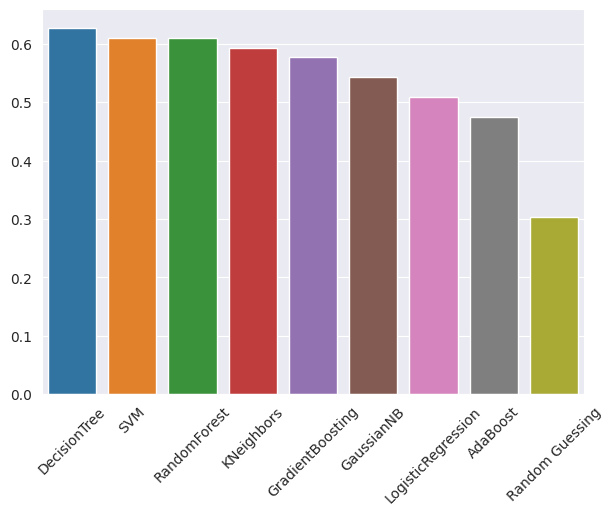

In [56]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(7,5))

values = np.array([0.5084745762711864,0.5932203389830508,0.6101694915254238,
                   0.6101694915254238,0.6271186440677966,0.5423728813559322,
                   0.576271186440678,0.4745762711864407,0.3041250682928091])
labels = np.array(["LogisticRegression","KNeighbors","RandomForest","SVM","DecisionTree","GaussianNB","GradientBoosting","AdaBoost","Random Guessing"])
sns.barplot(x=labels[np.argsort(values)][::-1],y=np.sort(values)[::-1])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)    


# Feature importance
Furthermore, we select best algorithm using Leave-One-Out Cross Validation and report a score on a test set:

In [57]:
def LOOCV_features(clf,train_data):
    loo = LeaveOneOut()

    # initialize a list to store the scores
    scores = []
    
    X = train_data.drop(columns=["diag"])
    y = train_data.diag
    # iterate over the splits
    importances = np.zeros(len(X.columns))
    for train_index, test_index in loo.split(X):
        # get the training and test data for this split
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # fit the model on the training data and score it on the test data
        clf.fit(X_train, y_train)
        score = f1_score(y_test,clf.predict(X_test),average="macro")
        importances += clf.feature_importances_
        # store the score
        scores.append(score)

    # calculate and print the mean score
    return importances/len(X.columns),sum(scores) / len(scores)

### Full data

[Text(0, 0, 'BDI_II'),
 Text(1, 0, 'BAI'),
 Text(2, 0, 'ASRS - N'),
 Text(3, 0, 'ASRS'),
 Text(4, 0, 'BPQ'),
 Text(5, 0, 'ASRS - H'),
 Text(6, 0, 'AVLT3'),
 Text(7, 0, 'AVLT_SUM'),
 Text(8, 0, 'FLUENCY2'),
 Text(9, 0, 'TMT_B'),
 Text(10, 0, 'AVLT4'),
 Text(11, 0, 'AVLT5'),
 Text(12, 0, 'FLUENCY3'),
 Text(13, 0, 'STORY_DEL_TOTAL'),
 Text(14, 0, 'STORY_B'),
 Text(15, 0, 'STORY-TOTAL'),
 Text(16, 0, 'STORY_A_DEL'),
 Text(17, 0, 'AVLT_AGG'),
 Text(18, 0, 'SYMBOLS_HS'),
 Text(19, 0, 'ROCFT_30MIN'),
 Text(20, 0, 'STORY_B_DEL'),
 Text(21, 0, 'ROCFT_3MIN'),
 Text(22, 0, 'FLUENCY1'),
 Text(23, 0, 'TMT_A'),
 Text(24, 0, 'STORY_A'),
 Text(25, 0, 'AVLT_DEL'),
 Text(26, 0, 'KOGN_ODHAD'),
 Text(27, 0, 'DIGITSPAN_BW'),
 Text(28, 0, 'DIGITSPAN_TOT'),
 Text(29, 0, 'ROCFT_COPY'),
 Text(30, 0, 'AVLT1'),
 Text(31, 0, 'N_CET'),
 Text(32, 0, 'DIGITSPAN_FW'),
 Text(33, 0, 'AVLT-B'),
 Text(34, 0, 'AVLT6'),
 Text(35, 0, 'AVLT2'),
 Text(36, 0, 'TMT_B_MISTAKES'),
 Text(37, 0, 'TMT_A_MISTAKES'),
 Text(38, 0, 'WUR

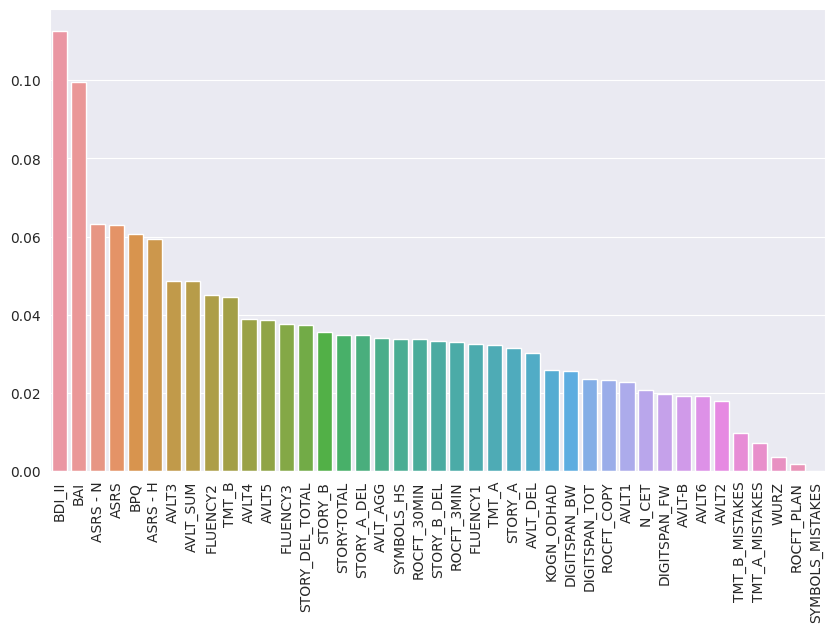

In [76]:
feature_importances_full,score = LOOCV_features(RandomForestClassifier(random_state=42),d)

fig, ax = plt.subplots(figsize=(10,6))

sns.barplot(x=d.drop(columns=['diag']).columns[np.argsort(feature_importances_full)[::-1]],y=np.sort(feature_importances_full)[::-1],ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

### Collapsed data

[Text(0, 0, 'ASRS_AGG'),
 Text(1, 0, 'BPQ'),
 Text(2, 0, 'BAI'),
 Text(3, 0, 'KOGN_ODHAD'),
 Text(4, 0, 'STORY_AGG'),
 Text(5, 0, 'FLUENCY_AGG'),
 Text(6, 0, 'TMT_AGG'),
 Text(7, 0, 'N_CET'),
 Text(8, 0, 'AVLT_AGG'),
 Text(9, 0, 'BDI_II'),
 Text(10, 0, 'SYMBOLS_HS'),
 Text(11, 0, 'DIGITSPAN_AGG'),
 Text(12, 0, 'ROCFT_AGG'),
 Text(13, 0, 'MISTAKES_AGG'),
 Text(14, 0, 'WURZ')]

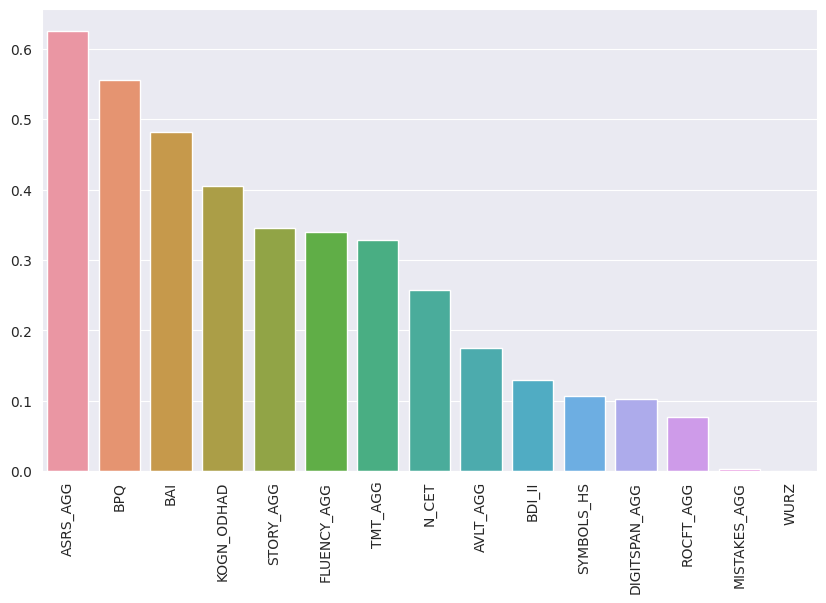

In [77]:
feature_importances_collapsed,score = LOOCV_features(DecisionTreeClassifier(random_state=42),df)

fig, ax = plt.subplots(figsize=(10,6))

sns.barplot(x=df.drop(columns=['diag']).columns[np.argsort(feature_importances_collapsed)[::-1]],y=np.sort(feature_importances_collapsed)[::-1],ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

### Final thresholding

#### full data

In [70]:
scores = []
for i in tqdm(range(1,len(d.columns))):
    idx=np.argsort(feature_importances_full)[-i:]
    t_data = d.drop(columns=['diag']).iloc[:,idx]
    t_data['diag'] = d.diag
    scores.append(LOOCV(RandomForestClassifier(random_state=42),t_data))

100%|██████████| 41/41 [05:41<00:00,  8.33s/it]


In [71]:
print("Optimal number of most important features:",np.argmax(scores))

Optimal number of most important features: 9


<AxesSubplot: >

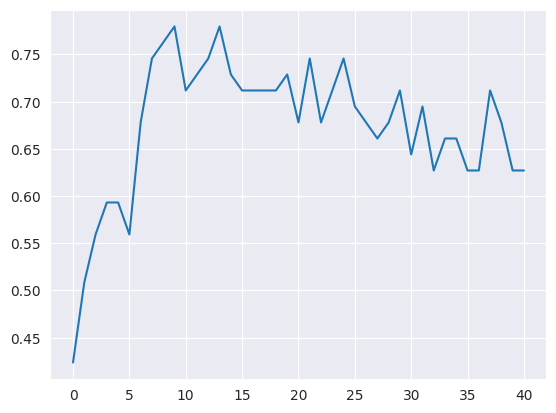

In [72]:
sns.lineplot(scores)

#### Collapsed data

In [73]:
scores = []
for i in tqdm(range(1,len(df.columns))):
    idx=np.argsort(feature_importances_collapsed)[-i:]
    t_data = df.drop(columns=['diag']).iloc[:,idx]
    t_data['diag'] = df.diag
    scores.append(LOOCV(DecisionTreeClassifier(random_state=42),t_data))

100%|██████████| 15/15 [00:02<00:00,  5.10it/s]


In [78]:
print("Optimal number of most important features:",np.argmax(scores))

Optimal number of most important features: 6


<AxesSubplot: >

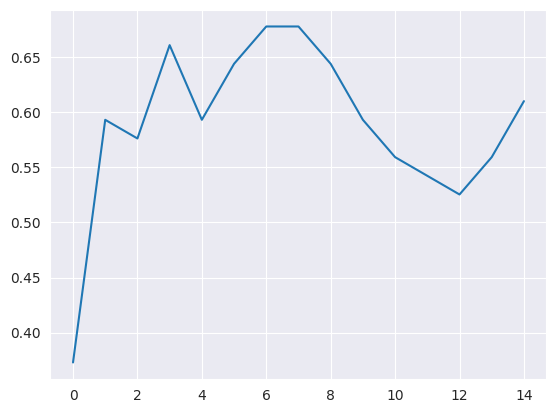

In [79]:
sns.set_style("darkgrid")
sns.lineplot(scores)